# Function Declarations & Library Imports

* import necessary Python libraries and the definition of key functions used throughout the analysis of the FIFA World Cup data.


In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps
import requests


In [2]:
with open('api.txt') as file:
    API_KEY = file.readline()
    file.close

In [3]:
# Function to determine numeric match outcome
def determine_numeric_outcome(row):
    if row['Home Team Goals'] > row['Away Team Goals']:
        return 1  # Home win
    elif row['Home Team Goals'] < row['Away Team Goals']:
        return -1  # Away win
    else:
        return 0  # Draw

# Function to check if a specific team won a match
def did_team_win(row, team_name):
    if row['Home Team Name'] == team_name:
        return 1 if row['Home Team Goals'] > row['Away Team Goals'] else -1 if row['Home Team Goals'] < row['Away Team Goals'] else 0
    elif row['Away Team Name'] == team_name:
        return 1 if row['Away Team Goals'] > row['Home Team Goals'] else -1 if row['Away Team Goals'] < row['Home Team Goals'] else 0
    return None

# Function to calculate the win rate of a team
def calculate_win_rate(matches, team_name):
    outcomes = [did_team_win(row, team_name) for index, row in matches.iterrows()]
    games_played = len([outcome for outcome in outcomes if outcome is not None])
    wins = sum(1 for result in outcomes if result == 1)
    return wins / games_played if games_played > 0 else 0

# Function to parse match events
def parse_event(event):
    events = {'G': 0, 'OG': 0, 'Y': 0, 'R': 0, 'SY': 0, 'P': 0, 'MP': 0, 'I': 0, 'O': 0}
    if pd.isna(event):
        return events
    for part in event.split():
        if 'G' in part:
            events['G'] += 1
        elif 'OG' in part:
            events['OG'] += 1
        elif 'Y' in part:
            events['Y'] += 1
        elif 'R' in part:
            events['R'] += 1
        elif 'SY' in part:
            events['SY'] += 1
        elif 'P' in part:
            events['P'] += 1
        elif 'MP' in part:
            events['MP'] += 1
        elif 'I' in part:
            events['I'] += 1
        elif 'O' in part:
            events['O'] += 1
    return events

# Geocoding Function
def geocode_country(country_name):
    geocode_url = f"https://maps.googleapis.com/maps/api/geocode/json?address={country_name}&key={API_KEY}"
    response = requests.get(geocode_url)
    if response.status_code == 200:
        result = response.json()['results'][0]
        return result['geometry']['location']
    return None

def calc_linear_regression(X_input, y):
    X = np.hstack([np.ones((X_input.shape[0], 1)), X_input])
    A = X.T.dot(X)
    b = X.T.dot(y)
    w = np.linalg.inv(A).dot(b)
    return w

# Loading and Cleaning WorldCupMatches Dataset
In this section, we load the `WorldCupMatches.csv` dataset and perform necessary data cleaning steps including handling missing values and duplicates.


In [4]:
# Loading the WorldCupMatches.csv dataset
world_cup_matches_path = 'WorldCupMatches.csv'
world_cup_matches = pd.read_csv(world_cup_matches_path)

# Displaying basic information of the dataset
print(world_cup_matches.info())
print(world_cup_matches.describe())
print(world_cup_matches.head())

# Data Cleaning for WorldCupMatches.csv
# Dropping rows with missing data
world_cup_matches.dropna(inplace=True, how='all')
print(world_cup_matches.info())

# Dropping duplicate rows
world_cup_matches.drop_duplicates(inplace=True)  

# Filling missing values in 'Attendance'
mean_attendance_by_group = world_cup_matches.groupby(['Year', 'Stage'])['Attendance'].mean()
for (year, stage), mean_attendance in mean_attendance_by_group.items():
    condition = (world_cup_matches['Year'] == year) & (world_cup_matches['Stage'] == stage) & (world_cup_matches['Attendance'].isna())
    world_cup_matches.loc[condition, 'Attendance'] = mean_attendance

# Convert columns to the appropriate types
world_cup_matches['Datetime'] = pd.to_datetime(world_cup_matches['Datetime'])
cols_to_int = ['Year', 'Home Team Goals', 'Away Team Goals', 'Attendance', 'Half-time Home Goals', 'Half-time Away Goals', 'RoundID', 'MatchID']
for col in cols_to_int:
    world_cup_matches[col] = world_cup_matches[col].astype(int)

# Replace NaNs in 'Win conditions' with "Normal"
world_cup_matches['Win conditions'] = world_cup_matches['Win conditions'].fillna('Normal')

# Calculate 'Goal Gap' and handle outliers
world_cup_matches['Goal Gap'] = abs(world_cup_matches['Home Team Goals'] - world_cup_matches['Away Team Goals'])
Q1 = world_cup_matches['Goal Gap'].quantile(0.25)
Q3 = world_cup_matches['Goal Gap'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 6.0 * IQR
world_cup_matches = world_cup_matches[world_cup_matches['Goal Gap'] <= upper_bound]

# Add a column for total number of goals in the game
world_cup_matches['Match Goals'] = world_cup_matches['Home Team Goals'] + world_cup_matches['Away Team Goals']

# Discretize 'Attendance'
attendance_bins = [0, 30000, 60000, 90000, 120000]
bin_labels = ['Low', 'Medium', 'High', 'Very High']
world_cup_matches['Attendance Category'] = pd.cut(world_cup_matches['Attendance'], bins=attendance_bins, labels=bin_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  852 non-null    float64
 1   Datetime              852 non-null    object 
 2   Stage                 852 non-null    object 
 3   Stadium               852 non-null    object 
 4   City                  852 non-null    object 
 5   Home Team Name        852 non-null    object 
 6   Home Team Goals       852 non-null    float64
 7   Away Team Goals       852 non-null    float64
 8   Away Team Name        852 non-null    object 
 9   Win conditions        852 non-null    object 
 10  Attendance            850 non-null    float64
 11  Half-time Home Goals  852 non-null    float64
 12  Half-time Away Goals  852 non-null    float64
 13  Referee               852 non-null    object 
 14  Assistant 1           852 non-null    object 
 15  Assistant 2          

# Loading and Cleaning WorldCupPlayers Dataset
Load the `WorldCupPlayers.csv` dataset and clean it by filling missing values, removing duplicates, and parsing event data.

In [5]:
# Loading the WorldCupPlayers.csv dataset
world_cup_players_path = 'WorldCupPlayers.csv'
world_cup_players = pd.read_csv(world_cup_players_path)

# Displaying basic information of the dataset
print(world_cup_players.info())
print(world_cup_players.head())

# Cleaning the WorldCupPlayers.csv dataset
# Handling Missing Data
world_cup_players['Position'] = world_cup_players['Position'].fillna('FieldPlayer')
world_cup_players['Event'] = world_cup_players['Event'].fillna('None')

# Remove Duplicates
world_cup_players.drop_duplicates(inplace=True)

# Parsing and splitting event data into separate columns
world_cup_players['Parsed Events'] = world_cup_players['Event'].apply(parse_event)
events_df = world_cup_players['Parsed Events'].apply(pd.Series)
world_cup_players = pd.concat([world_cup_players.drop(['Parsed Events'], axis=1), events_df], axis=1)

# Verify the cleaned data
print(world_cup_players.info())
print(world_cup_players.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   RoundID        37784 non-null  int64 
 1   MatchID        37784 non-null  int64 
 2   Team Initials  37784 non-null  object
 3   Coach Name     37784 non-null  object
 4   Line-up        37784 non-null  object
 5   Shirt Number   37784 non-null  int64 
 6   Player Name    37784 non-null  object
 7   Position       4143 non-null   object
 8   Event          9069 non-null   object
dtypes: int64(3), object(6)
memory usage: 2.6+ MB
None
   RoundID  MatchID Team Initials           Coach Name Line-up  Shirt Number  \
0      201     1096           FRA  CAUDRON Raoul (FRA)       S             0   
1      201     1096           MEX     LUQUE Juan (MEX)       S             0   
2      201     1096           FRA  CAUDRON Raoul (FRA)       S             0   
3      201     1096           MEX     LUQUE 

# Loading and Cleaning WorldCups Dataset
Load the `WorldCups.csv` dataset and clean it by converting strings to intergers & handling a special entry


In [6]:
# Loading the WorldCups.csv dataset
world_cups_path = 'WorldCups.csv'
world_cups = pd.read_csv(world_cups_path)

# Handling the 'Korea/Japan' entry
if 'Korea/Japan' in world_cups['Country'].values:
    korea_japan_row = world_cups[world_cups['Country'] == 'Korea/Japan']
    korea_row = korea_japan_row.copy()
    korea_row['Country'] = 'Korea Republic'
    japan_row = korea_japan_row.copy()
    japan_row['Country'] = 'Japan'
    world_cups = pd.concat([world_cups, korea_row, japan_row])
    world_cups = world_cups[world_cups['Country'] != 'Korea/Japan']

# Convert 'Attendance' from string to integer
world_cups['Total WorldCup Attendance'] = world_cups['Attendance'].str.replace('.', '', regex=False).astype(int) # https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html
world_cups.drop('Attendance', axis=1, inplace=True)

# Convert other columns to integers
cols_to_int = ['Year', 'GoalsScored', 'QualifiedTeams', 'MatchesPlayed']
world_cups[cols_to_int] = world_cups[cols_to_int].astype(int)

# Verify the cleaned data
print(world_cups.info())
print(world_cups.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 16
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Year                       21 non-null     int32 
 1   Country                    21 non-null     object
 2   Winner                     21 non-null     object
 3   Runners-Up                 21 non-null     object
 4   Third                      21 non-null     object
 5   Fourth                     21 non-null     object
 6   GoalsScored                21 non-null     int32 
 7   QualifiedTeams             21 non-null     int32 
 8   MatchesPlayed              21 non-null     int32 
 9   Total WorldCup Attendance  21 non-null     int32 
dtypes: int32(5), object(5)
memory usage: 1.4+ KB
None
   Year      Country      Winner      Runners-Up    Third      Fourth  \
0  1930      Uruguay     Uruguay       Argentina      USA  Yugoslavia   
1  1934        Italy       Italy  Cz

# Analysis
### (1) Win Rates of World Cup Host Countries

Uruguay: Win Rate When Hosting: 100.00%, Win Rate When Not Hosting: 32.00%
Italy: Win Rate When Hosting: 83.33%, Win Rate When Not Hosting: 48.00%
France: Win Rate When Hosting: 77.78%, Win Rate When Not Hosting: 39.62%
Brazil: Win Rate When Hosting: 53.85%, Win Rate When Not Hosting: 71.43%
Switzerland: Win Rate When Hosting: 50.00%, Win Rate When Not Hosting: 31.03%
Sweden: Win Rate When Hosting: 66.67%, Win Rate When Not Hosting: 29.55%
Chile: Win Rate When Hosting: 66.67%, Win Rate When Not Hosting: 25.93%
England: Win Rate When Hosting: 83.33%, Win Rate When Not Hosting: 37.70%
Mexico: Win Rate When Hosting: 55.56%, Win Rate When Not Hosting: 22.92%
Germany: Win Rate When Hosting: 71.43%, Win Rate When Not Hosting: 68.18%
Argentina: Win Rate When Hosting: 71.43%, Win Rate When Not Hosting: 52.05%
Spain: Win Rate When Hosting: 20.00%, Win Rate When Not Hosting: 52.54%
USA: Win Rate When Hosting: 25.00%, Win Rate When Not Hosting: 26.47%
South Africa: Win Rate When Hosting: 33.33%, 

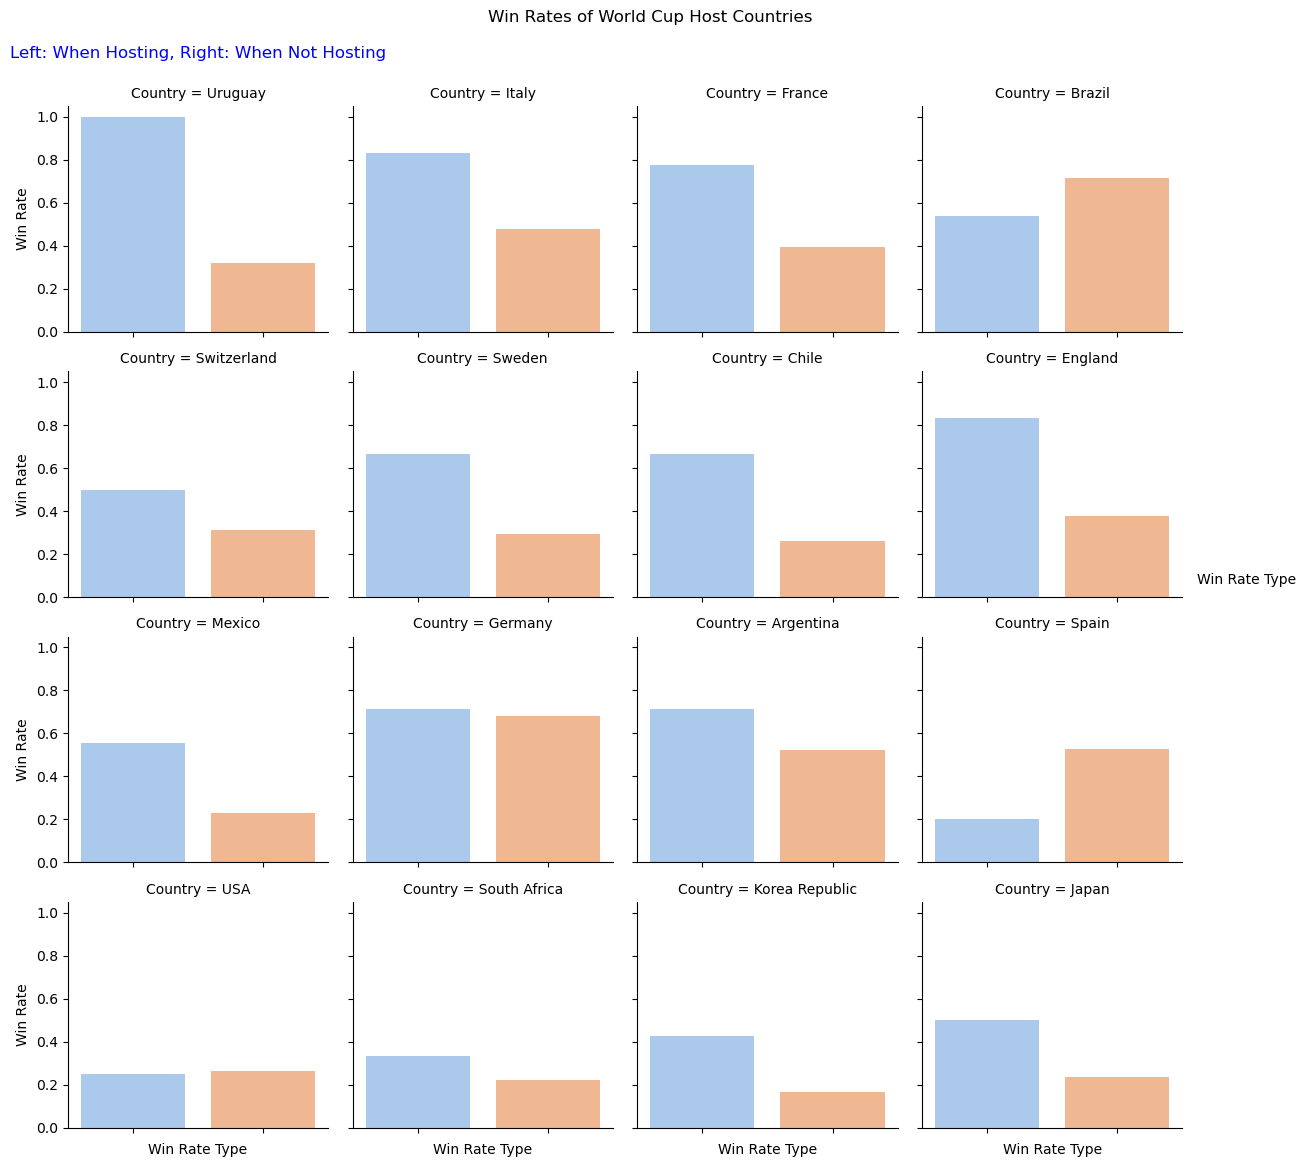

In [7]:
# Merging world_cup_matches with world_cups to get 'Year' in player_match_data
world_cup_matches_merged = world_cup_matches.merge(world_cups[['Year', 'Country']], on='Year', how='left')

# Calculating win rates for when countries are hosting and when they are not
host_win_rates = {country: calculate_win_rate(world_cup_matches_merged[world_cup_matches_merged['Country'] == country], country) for country in world_cups['Country'].unique()}
non_host_win_rates = {country: calculate_win_rate(world_cup_matches_merged[world_cup_matches_merged['Country'] != country], country) for country in world_cups['Country'].unique()}

# Displaying the win rates
for country in world_cups['Country'].unique():
    print(f"{country}: Win Rate When Hosting: {host_win_rates[country]:.2%}, Win Rate When Not Hosting: {non_host_win_rates[country]:.2%}")

# Creating FacetGrid for visualizing win rates
facet_data = []
for country in world_cups['Country'].unique():
    facet_data.append({'Country': country, 'Win Rate Type': 'When Hosting', 'Win Rate': host_win_rates[country]})
    facet_data.append({'Country': country, 'Win Rate Type': 'When Not Hosting', 'Win Rate': non_host_win_rates[country]})
facet_df = pd.DataFrame(facet_data)

# Define the order of the categories
win_rate_order = ['When Hosting', 'When Not Hosting'] # https://seaborn.pydata.org/generated/seaborn.barplot.html

# Creating the FacetGrid
g = sns.FacetGrid(facet_df, col='Country', col_wrap=4)
g = g.map(sns.barplot, 'Win Rate Type', 'Win Rate', order=win_rate_order, palette='pastel') 
g.add_legend(title='Win Rate Type')

for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Win Rates of World Cup Host Countries')
g.axes[0].text(0.5, 1.2, 'Left: When Hosting, Right: When Not Hosting', transform=g.axes[0].transAxes, horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='blue')
plt.show()

* table format

In [8]:
# Creating a DataFrame for display
win_rates_data = []
for country in world_cups['Country'].unique():
    win_rates_data.append({
        'Country': country, 
        'Win Rate When Hosting': f"{host_win_rates[country]:.2%}", 
        'Win Rate When Not Hosting': f"{non_host_win_rates[country]:.2%}"
    })

win_rates_df = pd.DataFrame(win_rates_data)

# Display the DataFrame
print("Win Rates of World Cup Host Countries:")
print(win_rates_df.to_string(index=False))

Win Rates of World Cup Host Countries:
       Country Win Rate When Hosting Win Rate When Not Hosting
       Uruguay               100.00%                    32.00%
         Italy                83.33%                    48.00%
        France                77.78%                    39.62%
        Brazil                53.85%                    71.43%
   Switzerland                50.00%                    31.03%
        Sweden                66.67%                    29.55%
         Chile                66.67%                    25.93%
       England                83.33%                    37.70%
        Mexico                55.56%                    22.92%
       Germany                71.43%                    68.18%
     Argentina                71.43%                    52.05%
         Spain                20.00%                    52.54%
           USA                25.00%                    26.47%
  South Africa                33.33%                    22.22%
Korea Republic  

* Percentage benefit of hosting

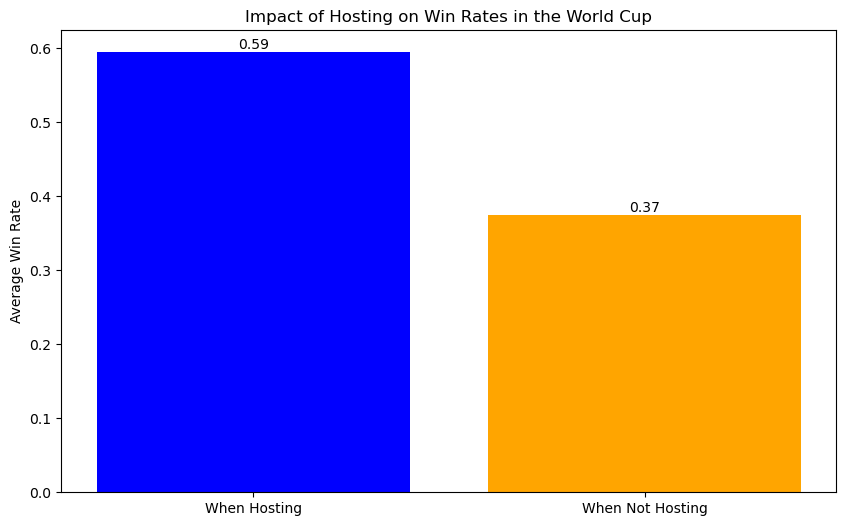

Percentage Benefit of Hosting: 58.58%


In [9]:
# Calculate the average win rate when hosting
average_host_win_rate = sum(host_win_rates.values()) / len(host_win_rates)

# Calculate the average win rate when not hosting
average_non_host_win_rate = sum(non_host_win_rates.values()) / len(non_host_win_rates)

# Calculate the percentage benefit of hosting
percentage_benefit = ((average_host_win_rate - average_non_host_win_rate) / average_non_host_win_rate) * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['When Hosting', 'When Not Hosting'], [average_host_win_rate, average_non_host_win_rate], color=['blue', 'orange'])
plt.title('Impact of Hosting on Win Rates in the World Cup')
plt.ylabel('Average Win Rate')
plt.text(0, average_host_win_rate, f'{average_host_win_rate:.2f}', ha='center', va='bottom')
plt.text(1, average_non_host_win_rate, f'{average_non_host_win_rate:.2f}', ha='center', va='bottom')
plt.show()

print(f"Percentage Benefit of Hosting: {percentage_benefit:.2f}%")


# (2) win rates, goals ratio

* win rates 

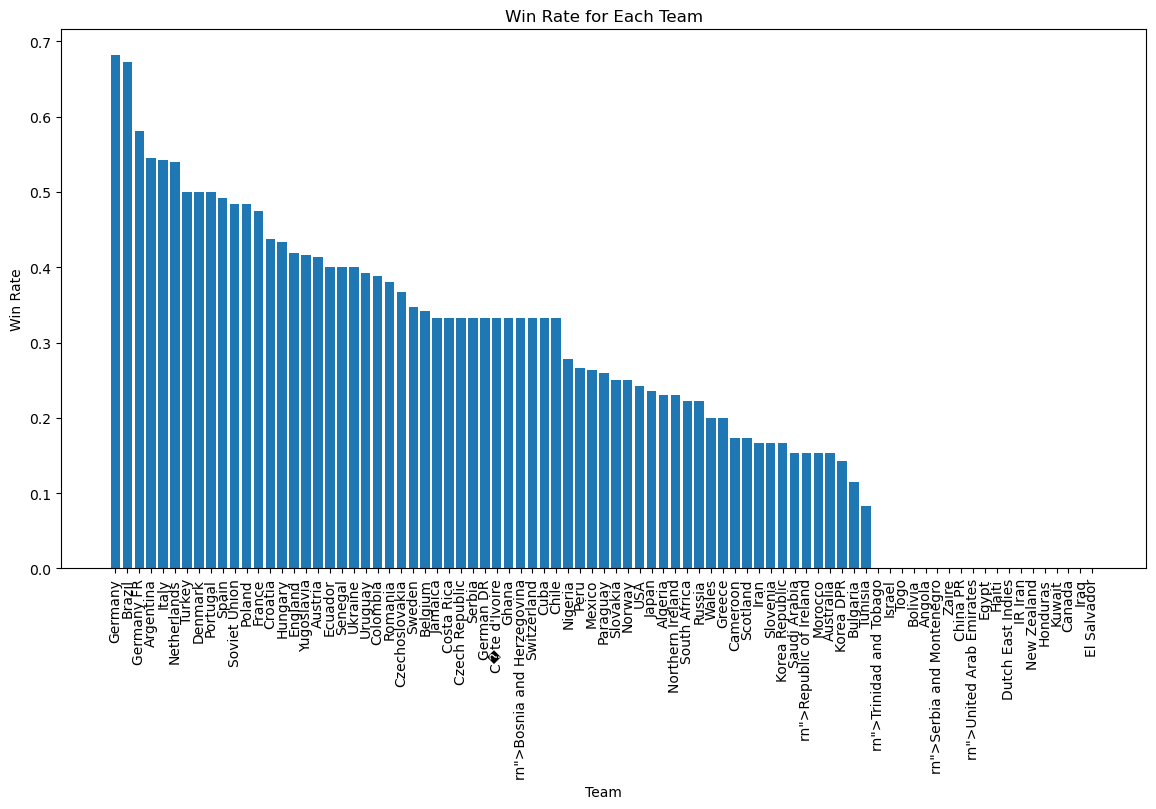

In [10]:
# Initializing dictionaries for team performance metrics
team_matches = {}
team_wins = {}
team_goals_made = {}
team_goals_conceded = {}

# Iterating through matches to update team performance metrics
for index, row in world_cup_matches.iterrows():
    home_team = row['Home Team Name']
    away_team = row['Away Team Name']
    home_goals = row['Home Team Goals']
    away_goals = row['Away Team Goals']
    match_outcome = determine_numeric_outcome(row)

    # Update matches played
    team_matches[home_team] = team_matches.get(home_team, 0) + 1
    team_matches[away_team] = team_matches.get(away_team, 0) + 1

    # Update wins and losses
    if match_outcome == 1:  # Home win
        team_wins[home_team] = team_wins.get(home_team, 0) + 1
    elif match_outcome == -1:  # Away win
        team_wins[away_team] = team_wins.get(away_team, 0) + 1

    # Update goals made and conceded
    team_goals_made[home_team] = team_goals_made.get(home_team, 0) + home_goals
    team_goals_conceded[home_team] = team_goals_conceded.get(home_team, 0) + away_goals
    team_goals_made[away_team] = team_goals_made.get(away_team, 0) + away_goals
    team_goals_conceded[away_team] = team_goals_conceded.get(away_team, 0) + home_goals

# Calculating win rates and goals ratio
team_win_rates = {team: team_wins.get(team, 0) / team_matches[team] for team in team_matches}
team_goals_ratio = {team: team_goals_made.get(team, 0) / max(team_goals_conceded.get(team, 1), 1) for team in team_matches}

# Creating DataFrame from the calculated metrics
team_stats_df = pd.DataFrame({'Team': list(team_win_rates.keys()), 'Win Rate': list(team_win_rates.values()), 'Goals Ratio': [team_goals_ratio[team] for team in team_win_rates.keys()]})

# Sorting and plotting the metrics
sorted_teams_by_win_rate = team_stats_df.sort_values(by='Win Rate', ascending=False)
sorted_teams_by_goals_ratio = team_stats_df.sort_values(by='Goals Ratio', ascending=False)

plt.figure(figsize=(14, 7))
plt.bar(sorted_teams_by_win_rate['Team'], sorted_teams_by_win_rate['Win Rate'])
plt.title('Win Rate for Each Team')
plt.xlabel('Team')
plt.ylabel('Win Rate')
plt.xticks(rotation=90)
plt.show()

* win rates

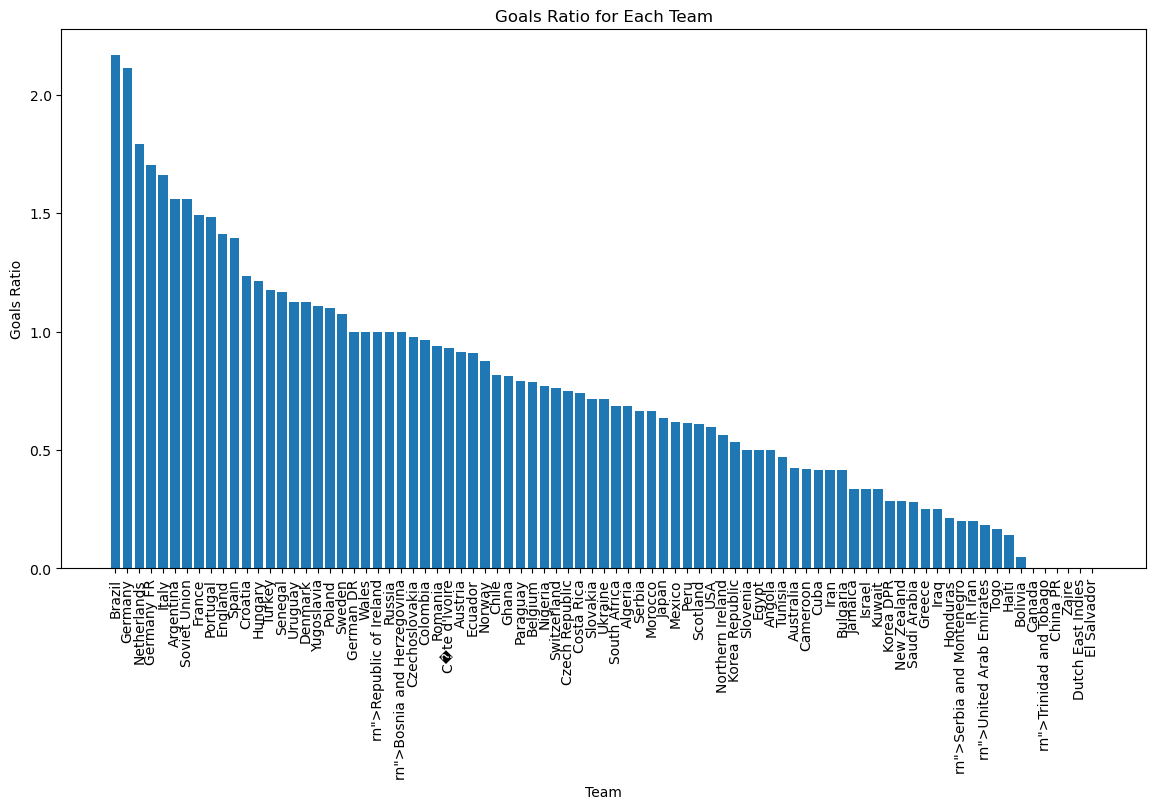

In [11]:
plt.figure(figsize=(14, 7))
plt.bar(sorted_teams_by_goals_ratio['Team'], sorted_teams_by_goals_ratio['Goals Ratio'])
plt.title('Goals Ratio for Each Team')
plt.xlabel('Team')
plt.ylabel('Goals Ratio')
plt.xticks(rotation=90)
plt.show()

* correlation between win rate and goals ratio

In [12]:
# Analyzing correlation between win rate and goals ratio
correlation_win_goals = team_stats_df[['Win Rate', 'Goals Ratio']].corr().round(2)
print(correlation_win_goals)

             Win Rate  Goals Ratio
Win Rate         1.00         0.91
Goals Ratio      0.91         1.00


* Visualizing the correlation matrix using a heatmap

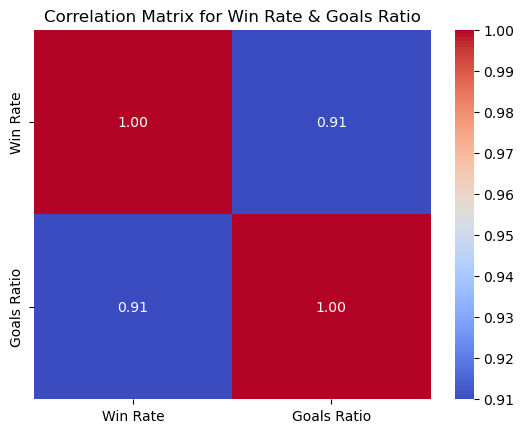

In [13]:
sns.heatmap(correlation_win_goals, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Win Rate & Goals Ratio')
plt.show()

* Teams by Win Rate and Goals Ratio (+ linear regression)

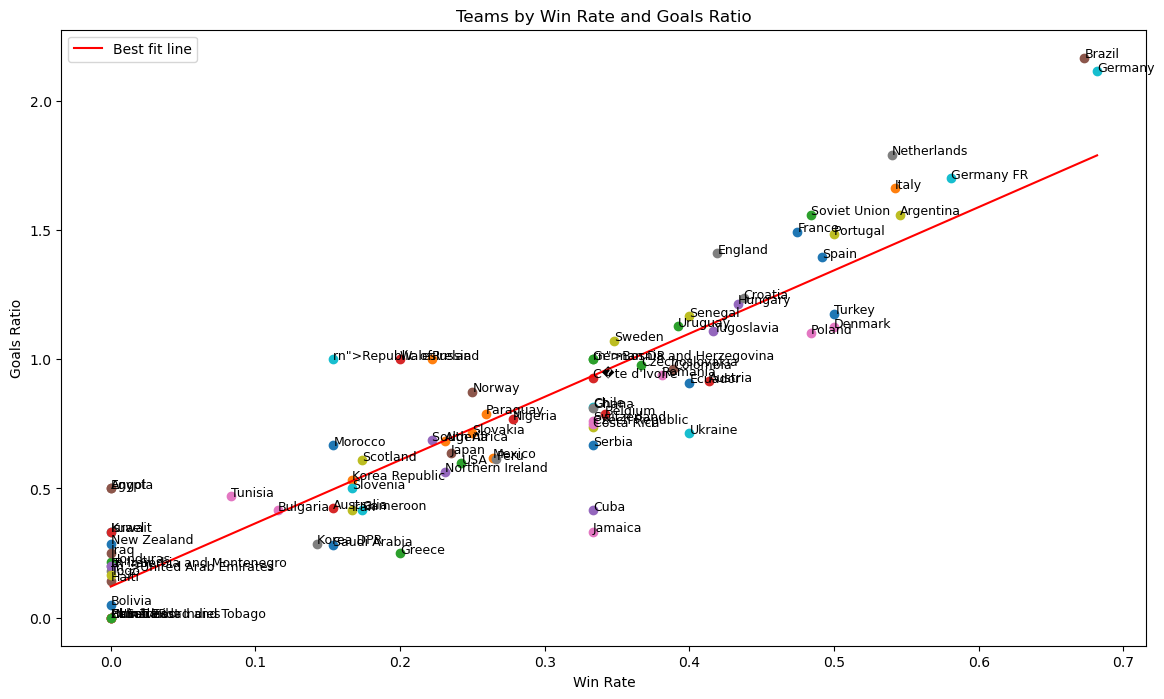

In [14]:
X_input = team_stats_df['Win Rate'].values.reshape(-1, 1) 
y = team_stats_df['Goals Ratio'].values

# Calculate the weights for linear regression
weights = calc_linear_regression(X_input, y)

# The weights vector contains [intercept, slope]
intercept, slope = weights

# Plotting Teams by Win Rate and Goals Ratio with Annotations
plt.figure(figsize=(14, 8))
for i in range(len(team_stats_df)):
    plt.scatter(team_stats_df['Win Rate'][i], team_stats_df['Goals Ratio'][i])
    plt.text(team_stats_df['Win Rate'][i], team_stats_df['Goals Ratio'][i], team_stats_df['Team'][i], fontsize=9)

# Prepare data for the regression line
x_values = np.linspace(min(team_stats_df['Win Rate']), max(team_stats_df['Win Rate']), 100)
y_values = intercept + slope * x_values

# Draw the line of best fit
plt.plot(x_values, y_values, color='red', label='Best fit line')

plt.title('Teams by Win Rate and Goals Ratio')
plt.xlabel('Win Rate')
plt.ylabel('Goals Ratio')
plt.legend()
plt.show()

* the most fortunate(or efficient) & unfortunate(or inefficient) team

In [15]:
# Get top and bottom team for win ratio
top_win_rate = sorted_teams_by_win_rate.head(1)
bottom_win_rate = sorted_teams_by_win_rate.tail(1)

# Get top and bottom team for goals ratio
top_goals_ratio = sorted_teams_by_goals_ratio.head(1)
bottom_goals_ratio = sorted_teams_by_goals_ratio.tail(1)

# Display the results
print("Top team by Win Rate:")
print(top_win_rate[['Team', 'Win Rate']])
print("\nBottom team by Win Rate:")
print(bottom_win_rate[['Team', 'Win Rate']])
print("\nTop team by Goals Ratio:")
print(top_goals_ratio[['Team', 'Goals Ratio']])
print("\nBottom team by Goals Ratio:")
print(bottom_goals_ratio[['Team', 'Goals Ratio']])

Top team by Win Rate:
       Team  Win Rate
19  Germany  0.681818

Bottom team by Win Rate:
           Team  Win Rate
41  El Salvador       0.0

Top team by Goals Ratio:
     Team  Goals Ratio
5  Brazil     2.166667

Bottom team by Goals Ratio:
           Team  Goals Ratio
41  El Salvador          0.0


* teams that are particularly good at scoring but not as effective at winning and the teams that are good at winning but not as high-scoring (These teams were selected based on their Win/Goals Ratio).


In [16]:
# Calculate Win Rate / Goals Ratio for each team
team_stats_df['Win/Goals Ratio'] = team_stats_df['Win Rate'] / team_stats_df['Goals Ratio']
# Filter out teams with 0 in goals ratio or win ratio to avoid division by zero
filtered_team_stats = team_stats_df[(team_stats_df['Goals Ratio'] > 0) & (team_stats_df['Win Rate'] > 0)]
# Find the team with the lowest Win/Goals Ratio (Good at Scoring but Not Winning) but with a Goals Ratio > 0.5
good_scoring_not_winning = filtered_team_stats[filtered_team_stats['Goals Ratio'] > 0.5].sort_values(by='Win/Goals Ratio').head(1)
# Find the team with the highest Win/Goals Ratio (Good at Winning but Not Scoring)
good_winning_not_scoring = filtered_team_stats.sort_values(by='Win/Goals Ratio', ascending=False).head(1)
print(good_scoring_not_winning)
print(good_winning_not_scoring)

                       Team  Win Rate  Goals Ratio  Win/Goals Ratio
59  rn">Republic of Ireland  0.153846          1.0         0.153846
       Team  Win Rate  Goals Ratio  Win/Goals Ratio
66  Jamaica  0.333333     0.333333              1.0


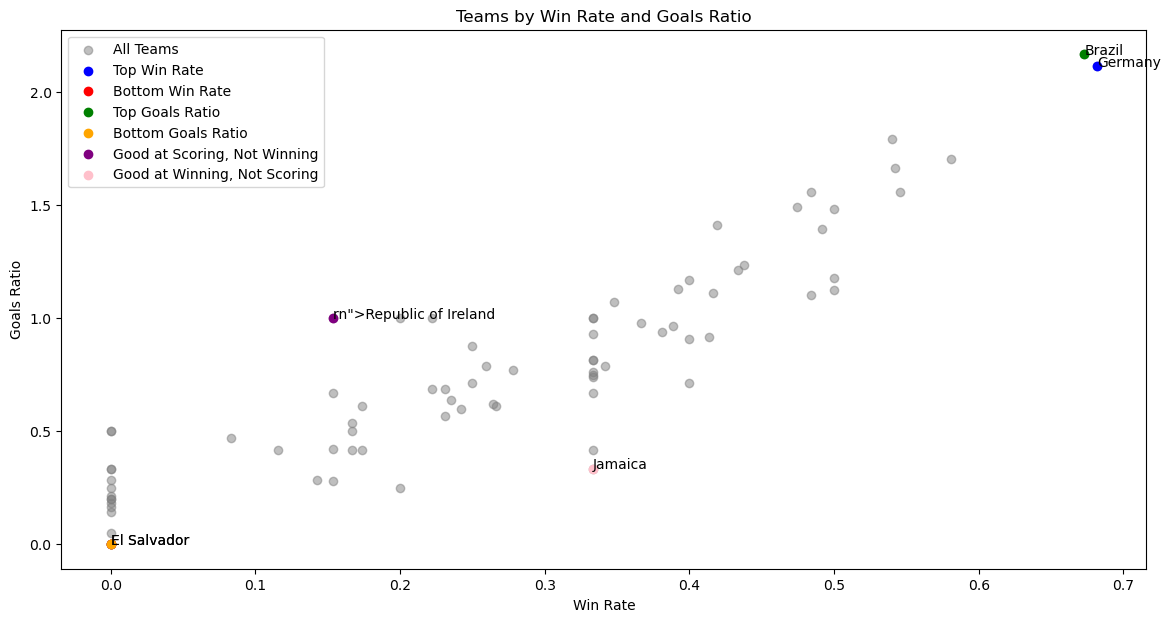

In [17]:
# Visualization
plt.figure(figsize=(14, 7))

# Plot all teams
plt.scatter(team_stats_df['Win Rate'], team_stats_df['Goals Ratio'], color='gray', alpha=0.5, label='All Teams')

# The top and bottom team by win ratio
plt.scatter(top_win_rate['Win Rate'], top_win_rate['Goals Ratio'], color='blue', label='Top Win Rate')
plt.scatter(bottom_win_rate['Win Rate'], bottom_win_rate['Goals Ratio'], color='red', label='Bottom Win Rate')

# The top and bottom team by goals ratio
plt.scatter(top_goals_ratio['Win Rate'], top_goals_ratio['Goals Ratio'], color='green', label='Top Goals Ratio')
plt.scatter(bottom_goals_ratio['Win Rate'], bottom_goals_ratio['Goals Ratio'], color='orange', label='Bottom Goals Ratio')

# The most fortunate & unfortunate teams
plt.scatter(good_scoring_not_winning['Win Rate'], good_scoring_not_winning['Goals Ratio'], 
            color='purple', label='Good at Scoring, Not Winning')
plt.scatter(good_winning_not_scoring['Win Rate'], good_winning_not_scoring['Goals Ratio'], 
            color='pink', label='Good at Winning, Not Scoring')

# Texts
for i, row in top_win_rate.iterrows():
    plt.text(row['Win Rate'], row['Goals Ratio'], row['Team'])
for i, row in bottom_win_rate.iterrows():
    plt.text(row['Win Rate'], row['Goals Ratio'], row['Team'])
for i, row in top_goals_ratio.iterrows():
    plt.text(row['Win Rate'], row['Goals Ratio'], row['Team'])
for i, row in bottom_goals_ratio.iterrows():
    plt.text(row['Win Rate'], row['Goals Ratio'], row['Team'])
for i, row in good_scoring_not_winning.iterrows():
    plt.text(row['Win Rate'], row['Goals Ratio'], row['Team'])
for i, row in good_winning_not_scoring.iterrows():
    plt.text(row['Win Rate'], row['Goals Ratio'], row['Team'])

# Plotting
plt.title('Teams by Win Rate and Goals Ratio')
plt.xlabel('Win Rate')
plt.ylabel('Goals Ratio')
plt.legend()
plt.show()

* KDE Plot with Scatter Points for Win Rate and Goals Ratio

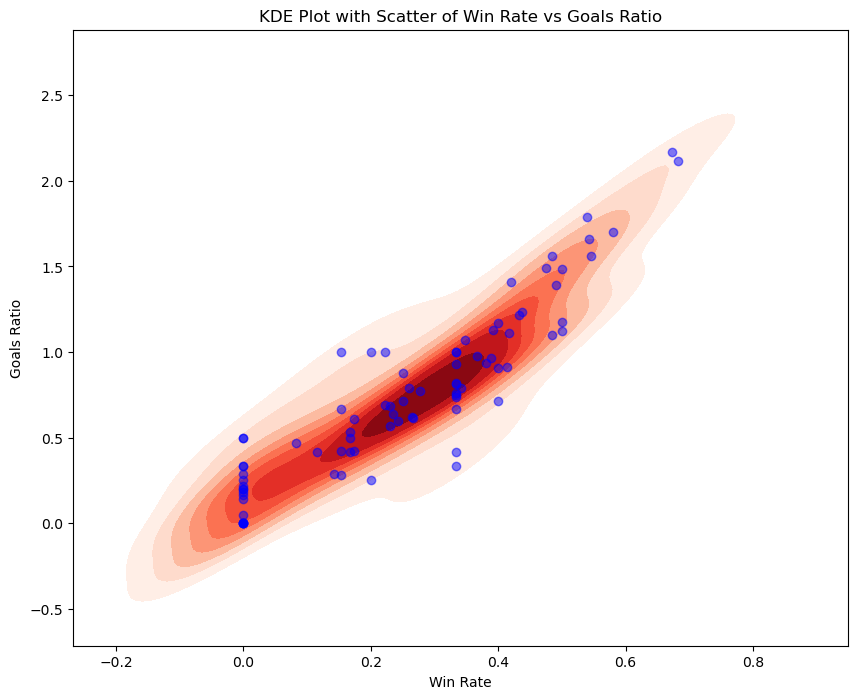

In [18]:
plt.figure(figsize=(10, 8))
sns.kdeplot(x=team_stats_df['Win Rate'], y=team_stats_df['Goals Ratio'], cmap="Reds", fill=True)
plt.scatter(team_stats_df['Win Rate'], team_stats_df['Goals Ratio'], color='blue', alpha=0.5)
plt.title('KDE Plot with Scatter of Win Rate vs Goals Ratio')
plt.xlabel('Win Rate')
plt.ylabel('Goals Ratio')
plt.show()

* Violin Plots for Win Rate and Goals Ratio in a Subplot


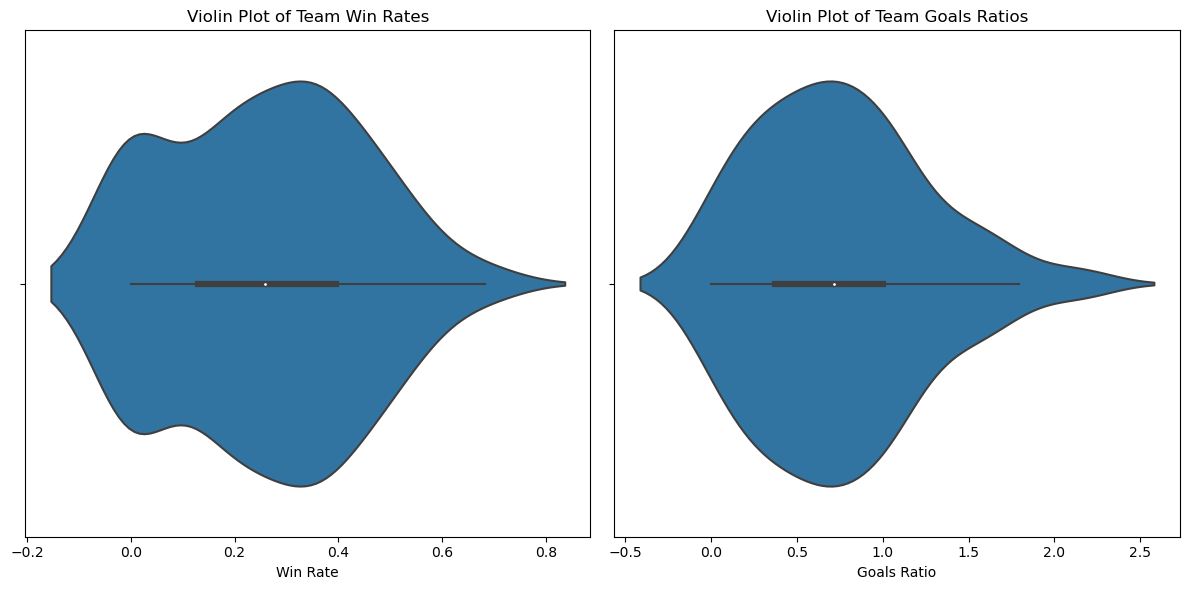

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(ax=axes[0], x=team_stats_df['Win Rate'])
axes[0].set_title('Violin Plot of Team Win Rates')
axes[0].set_xlabel('Win Rate')

sns.violinplot(ax=axes[1], x=team_stats_df['Goals Ratio'])
axes[1].set_title('Violin Plot of Team Goals Ratios')
axes[1].set_xlabel('Goals Ratio')

plt.tight_layout()
plt.show()

### (3) Google Maps Heatmap for World Cup Winners

In [20]:
# Counting the number of wins per country
win_counts = world_cups['Winner'].value_counts()

# Geocoding each winning country
locations = []
for country in win_counts.index:
    location = geocode_country(country)
    if location:
        locations.append({
            'country': country,
            'latitude': location['lat'],
            'longitude': location['lng'],
            'wins': win_counts[country]
        })

# Creating DataFrame for locations
locations_df = pd.DataFrame(locations)

* Google Maps Heatmap for World Cup Winners


In [21]:
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    locations_df[['latitude', 'longitude']], 
    weights=locations_df['wins'], 
    max_intensity=30,
    point_radius=20
)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(height='420px'))

used Google Colab to resolve a version issue with gmaps

### (4) Counting goals per player

In [22]:
# Counting goals per player
world_cup_players['Goals'] = world_cup_players['Event'].str.count('G').fillna(0)
player_goals = world_cup_players.groupby('Player Name')['Goals'].sum()

# Counting matches played per player
player_matches = world_cup_players.groupby('Player Name')['MatchID'].nunique()

# Calculating goals per game for each player
player_goals_per_game = player_goals / player_matches

# Sorting and displaying top players by goals per game
top_players_goals_per_game = player_goals_per_game.sort_values(ascending=False).head(16)

# Convert to DataFrame for better display
top_players_df = top_players_goals_per_game.reset_index()
top_players_df.columns = ['Player Name', 'Goals per Game']

# Display the DataFrame
print("Top Goal Scorers per Game:")
print(top_players_df.to_string(index=False))

Top Goal Scorers per Game:
       Player Name  Goals per Game
 Ernest WILIMOWSKI        4.000000
     Sandor KOCSIS        2.200000
     Just FONTAINE        2.166667
Abdel Rahman FAWZI        2.000000
 Guillermo STABILE        1.600000
         PREGUINHO        1.500000
        Sepp HUEGI        1.500000
     Leopold ANOUL        1.500000
    Bert PATENAUDE        1.333333
          LEONIDAS        1.333333
      Oleg SALENKO        1.333333
            ADEMIR        1.333333
         Pedro CEA        1.250000
  Gyula ZSENGELLER        1.250000
      Silvio PIOLA        1.250000
      Erich PROBST        1.200000


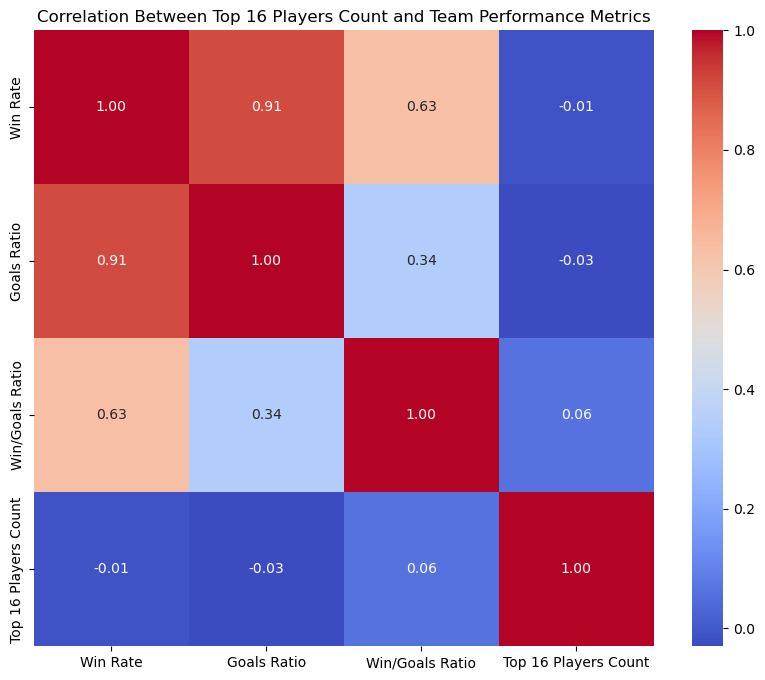

In [23]:
# Creating a mapping from player names to their team initials
player_teams_mapping = {}
for idx, row in world_cup_players[['Player Name', 'Team Initials']].drop_duplicates().iterrows():
    player_teams_mapping[row['Player Name']] = row['Team Initials']

# Use this mapping to find the teams of the top 16 scorers
top_16_scorers_teams = [player_teams_mapping[player] for player in top_players_goals_per_game.index]

# Counting the number of top 16 players in each team
top_players_count_per_team = pd.Series(top_16_scorers_teams).value_counts()

# Merge this count with the team performance metrics
team_performance_with_top_players = team_stats_df.copy()
team_performance_with_top_players['Top 16 Players Count'] = team_performance_with_top_players['Team'].map(top_players_count_per_team)
team_performance_with_top_players.fillna(0, inplace=True)  # Filling NaN values with 0

# Correlation analysis between the count of top players and team performance metrics
correlation_top_players_team_performance = team_performance_with_top_players.corr(numeric_only=True).round(2)

# Visualizing the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_top_players_team_performance, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Top 16 Players Count and Team Performance Metrics')
plt.show()

### (5) WorldCup Trend Analysis

In [24]:
# Merging to get 'Year' in player data
player_match_data = pd.merge(world_cup_players, world_cup_matches[['MatchID', 'Year']], on='MatchID')

# Summing up red and yellow cards per year
cards_per_year = player_match_data.groupby('Year')[['R', 'Y']].sum()

# Merging cards data with world_cups
world_cups_time_analysis = world_cups.merge(cards_per_year, left_on='Year', right_index=True)
world_cups_time_analysis.sort_values(by='Year', inplace=True)

# Calculating Average Goals Per Game for each World Cup
world_cups_time_analysis['Avg Goals per Game'] = world_cups_time_analysis['GoalsScored'] / world_cups_time_analysis['MatchesPlayed']

# Calculating average cards per game
world_cups_time_analysis['Avg Red Cards per Game'] = world_cups_time_analysis['R'] / world_cups_time_analysis['MatchesPlayed']
world_cups_time_analysis['Avg Yellow Cards per Game'] = world_cups_time_analysis['Y'] / world_cups_time_analysis['MatchesPlayed']
world_cups_time_analysis.drop('R', axis=1, inplace=True)
world_cups_time_analysis.drop('Y', axis=1, inplace=True)

* plotting analysis

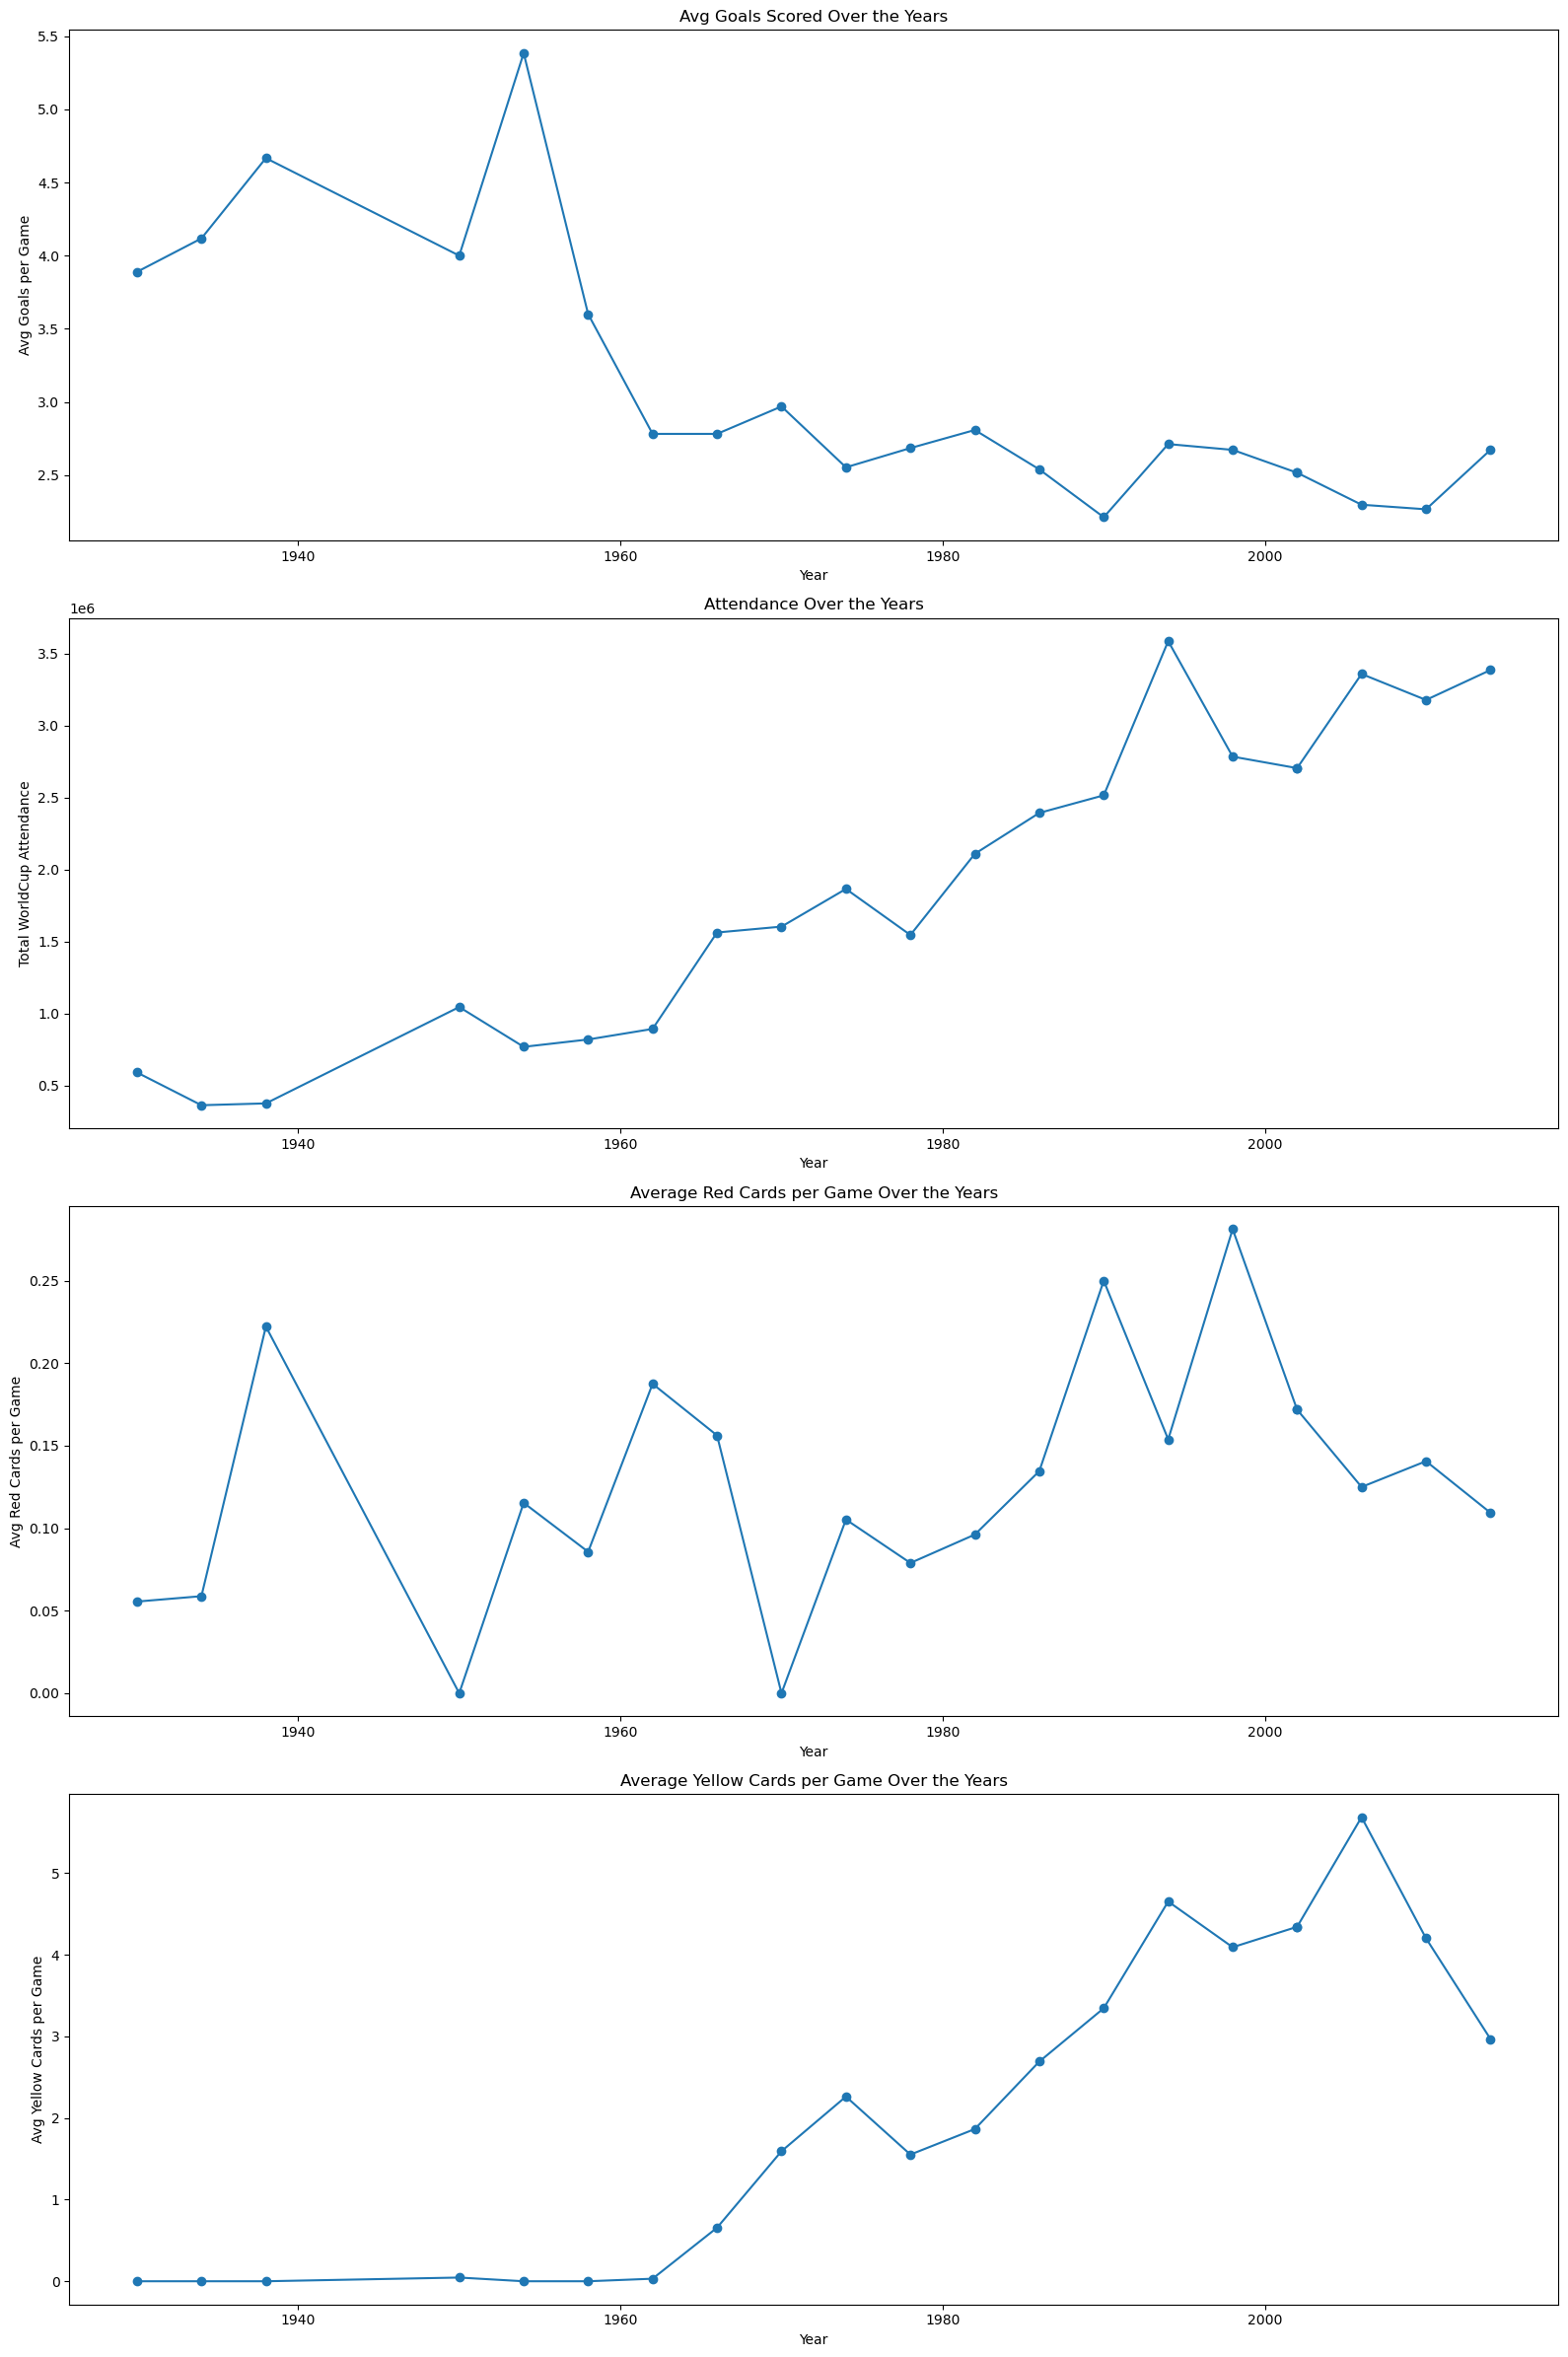

In [25]:
# Trend Analysis
fig, axs = plt.subplots(4, 1, figsize=(16, 24))
metrics = ['Avg Goals per Game', 'Total WorldCup Attendance', 'Avg Red Cards per Game', 'Avg Yellow Cards per Game']
titles = ['Avg Goals Scored Over the Years', 'Attendance Over the Years', 'Average Red Cards per Game Over the Years', 'Average Yellow Cards per Game Over the Years']

for i, metric in enumerate(metrics):
    axs[i].plot(world_cups_time_analysis['Year'], world_cups_time_analysis[metric], marker='o')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

https://cdn.theathletic.com/app/uploads/2022/12/02124812/wc_goals_per_game-1-2048x1536.png

* Visualizing the correlation matrix

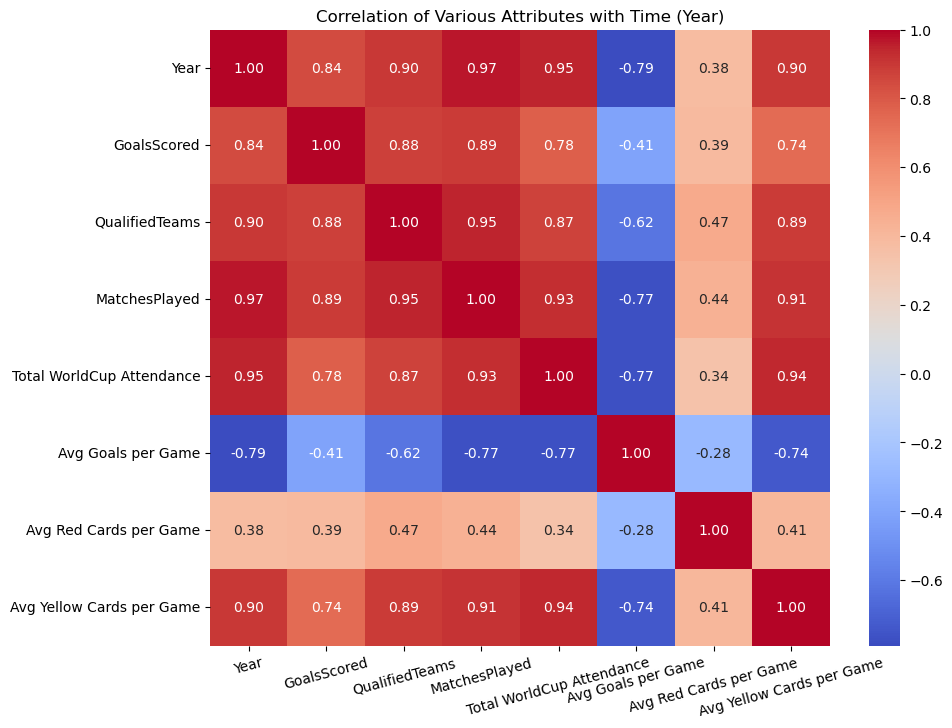

In [26]:
# Calculating the correlation matrix
correlation_with_time = world_cups_time_analysis.corr(numeric_only=True).round(2) #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_with_time, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Various Attributes with Time (Year)')
plt.xticks(rotation=15)
plt.show()

* KDE and Scatter Plot: Goals Scored vs Total World Cup Attendance

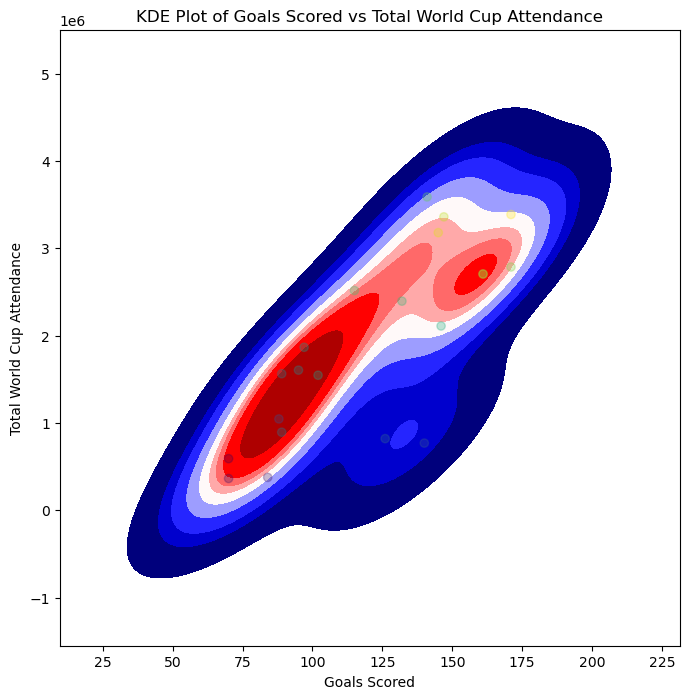

In [27]:
plt.figure(figsize=(8, 8))
sns.kdeplot(x=world_cups_time_analysis['GoalsScored'], y=world_cups_time_analysis['Total WorldCup Attendance'], cmap='seismic', fill=True)
plt.scatter(
    world_cups_time_analysis['GoalsScored'],
    world_cups_time_analysis['Total WorldCup Attendance'],
    c=world_cups_time_analysis['Year'],
    cmap='viridis',
    alpha=0.3
)
plt.xlabel('Goals Scored')
plt.ylabel('Total World Cup Attendance')
plt.title('KDE Plot of Goals Scored vs Total World Cup Attendance')
plt.show()

* KDE and Scatter Plot: Average Red Cards vs Average Yellow Cards per Game

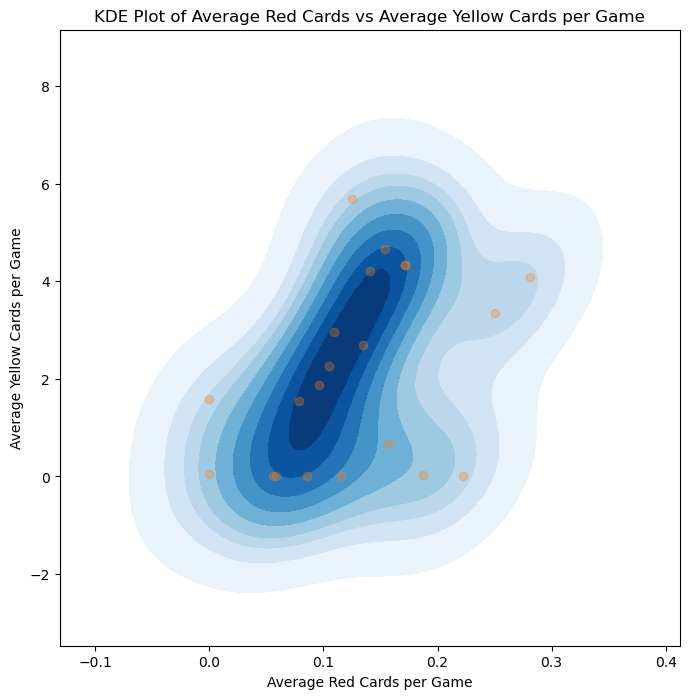

In [28]:
plt.figure(figsize=(8, 8))
sns.kdeplot(x=world_cups_time_analysis['Avg Red Cards per Game'], y=world_cups_time_analysis['Avg Yellow Cards per Game'], cmap='Blues', fill=True)
plt.scatter(world_cups_time_analysis['Avg Red Cards per Game'], world_cups_time_analysis['Avg Yellow Cards per Game'], alpha=0.3)
plt.xlabel('Average Red Cards per Game')
plt.ylabel('Average Yellow Cards per Game')
plt.title('KDE Plot of Average Red Cards vs Average Yellow Cards per Game')
plt.show()
